In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
pip install mealpy

In [17]:
%matplotlib inline
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from mealpy import FloatVar, MPA


Cell 2: Định nghĩa các hàm hỗ trợ

In [18]:
########################################
# 1) Hàm tính Mean, Variance, Entropy từ ảnh (hoặc kênh đơn)
########################################
def compute_mean_variance_entropy(gray_img):
    """
    Tính mean, variance, entropy cho ảnh dạng grayscale.
    """
    mean_val = np.mean(gray_img)
    var_val = np.var(gray_img)
    hist = cv2.calcHist([gray_img], [0], None, [256], [0, 256]).ravel()
    hist = hist / (np.sum(hist) + 1e-12)
    hist = hist[hist > 0]
    entropy_val = -np.sum(hist * np.log2(hist + 1e-12))
    return mean_val, var_val, entropy_val

########################################
# 2) Hàm tính gradient measure (độ sắc nét) trên ảnh grayscale
########################################
def compute_gradient_measure(gray_img):
    """
    Tính trung bình độ lớn gradient sử dụng Sobel trên ảnh grayscale.
    """
    sobelx = cv2.Sobel(gray_img, cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_img, cv2.CV_32F, 0, 1, ksize=3)
    grad = np.sqrt(sobelx**2 + sobely**2)
    return np.mean(grad)

########################################
# 3) Hàm tính PSNR giữa 2 ảnh (giả sử ảnh ở dải [0,255])
########################################
def compute_psnr(img1, img2):
    """
    Tính PSNR giữa 2 ảnh có cùng kích thước.
    """
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse < 1e-12:
        return 100.0
    psnr = 10 * math.log10((255.0 ** 2) / mse)
    return psnr

########################################
# 4) Hàm áp dụng gamma correction & alphaV trên kênh V (không có bước nhân gain)
########################################
def apply_gamma_alphaV_minmax(image, gamma_val, alphaV):
    """
    Quy trình:
      - Chuyển ảnh sang HSV.
      - Tách kênh V và chuẩn hóa: u = (V - v_min) / (v_max - v_min)
      - Áp dụng gamma correction: w = u^gamma_val.
      - Nhân với alphaV và chuyển về thang [0,255].
      - Ghép lại kênh H, S, V và chuyển về BGR.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
    v_channel = hsv[:, :, 2]
    v_min = np.min(v_channel)
    v_max = np.max(v_channel)
    u = (v_channel - v_min) / (v_max - v_min + 1e-12)
    w = np.power(u, gamma_val)
    v_new = alphaV * w * 255.0
    v_new = np.clip(v_new, 0, 255)
    hsv[:, :, 2] = v_new
    hsv = hsv.astype(np.uint8)
    corrected_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return corrected_bgr

########################################
# 5) Hàm CLAHE và nhân betaL trên kênh L, sau đó chuyển về HSV và áp dụng Unsharp Masking trên kênh V
########################################
def clahe_and_betaL_V_unsharp(image, betaL, amount, kernel_size=(5,5), sigma=0.5):
    """
    Quy trình:
      - Chuyển ảnh từ BGR sang LAB.
      - Tách kênh L, a, b.
      - Áp dụng CLAHE lên kênh L.
      - Nhân L_clahe với betaL và clip về [0,255].
      - Chuyển ảnh LAB về BGR.
      - Chuyển ảnh đã tăng cường sang HSV, tách kênh V.
      - Áp dụng Unsharp Masking trên kênh V:
            + Tính blurred_V bằng Gaussian Blur với kernel_size và sigma.
            + Tính mask = V - blurred_V.
            + Tính V_sharp = V + amount * mask.
      - Ghép lại kênh H, S với V_sharp và chuyển về BGR.
    """
    # Bước 1: Tăng cường kênh L bằng CLAHE và nhân betaL
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    L_clahe = clahe.apply(L)
    L_new = betaL * L_clahe.astype(np.float32)
    L_new = np.clip(L_new, 0, 255).astype(np.uint8)
    lab_new = cv2.merge((L_new, a, b))
    enhanced_bgr = cv2.cvtColor(lab_new, cv2.COLOR_LAB2BGR)

    # Bước 2: Chuyển ảnh sang HSV và tách kênh V
    hsv = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)

    # Bước 3: Áp dụng Unsharp Masking trên kênh V
    blurred_V = cv2.GaussianBlur(V, kernel_size, sigma)
    mask = cv2.subtract(V, blurred_V)
    V_sharp = V.astype(np.float32) + amount * mask.astype(np.float32)
    V_sharp = np.clip(V_sharp, 0, 255).astype(np.uint8)

    hsv_sharp = cv2.merge((H, S, V_sharp))
    final_enhanced = cv2.cvtColor(hsv_sharp, cv2.COLOR_HSV2BGR)
    return final_enhanced

########################################
# 6) Hàm mục tiêu mới dựa trên kênh V
########################################
def objective_func(solution, original_img, E1, G1):
    """
    Bộ tham số: [gamma, alphaV, betaL, k]
    Tất cả chỉ số đều được tính trên kênh V (sau chuyển về từ HSV).
    """
    gamma_val, alphaV, betaL, k = solution

    # Bước 1: Áp dụng gamma correction & alphaV trên kênh V
    img_gamma_alpha = apply_gamma_alphaV_minmax(original_img, gamma_val, alphaV)
    # Bước 2: Tăng cường ảnh bằng CLAHE, nhân betaL và Unsharp Masking trên kênh V (trong HSV)
    img_enhanced = clahe_and_betaL_V_unsharp(img_gamma_alpha, betaL, amount=k)

    # Lấy kênh V của ảnh tăng cường
    hsv_enhanced = cv2.cvtColor(img_enhanced, cv2.COLOR_BGR2HSV)
    V_enhanced = hsv_enhanced[:, :, 2]
    # Lấy kênh V của ảnh gốc
    hsv_original = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)
    V_original = hsv_original[:, :, 2]

    # Tính các chỉ số trên kênh V của ảnh tăng cường
    mean_val, var_val, E2 = compute_mean_variance_entropy(V_enhanced)
    if mean_val < 1e-12: mean_val = 1e-12
    V_over_M = var_val / mean_val
    dE = E2 - E1
    # Tính gradient measure (độ sắc nét) trên kênh V
    G2 = compute_gradient_measure(V_enhanced)
    dG = G2 - G1
    # Tính PSNR giữa kênh V của ảnh tăng cường và ảnh gốc
    psnr_val = compute_psnr(V_enhanced, V_original)

    O_p = V_over_M * dE - (dG / (psnr_val + 1e-12))
    return -O_p

########################################
# 7) Tối ưu các tham số [gamma, alphaV, betaL, k] bằng MPA
########################################
def optimize_params(original_img, epochs=30, pop_size=30):
    hsv_orig = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)
    V_original = hsv_orig[:, :, 2]
    _, _, E1 = compute_mean_variance_entropy(V_original)
    G1 = compute_gradient_measure(V_original)

    def obj_wrapper(solution):
        return objective_func(solution, original_img, E1, G1)

    lb = (0.3, 0.9, 1.2, 0.9)
    ub = (1.3, 1.9, 1.9, 1.9)
    problem_dict = {
        "bounds": FloatVar(lb=lb, ub=ub, name="(gamma, alphaV, betaL, k)"),
        "obj_func": obj_wrapper,
        "minmax": "min",
    }
    model = MPA.OriginalMPA(epoch=epochs, pop_size=pop_size)
    best = model.solve(problem_dict)
    return best.solution, best.target.fitness
########################################
# 9) Hàm đánh giá chất lượng ảnh
########################################
def evaluate_image_quality(img_rgb):
    """
    Tính 4 chỉ số chất lượng ảnh: Mean Brightness, Contrast (Variance), Entropy, Sharpness.
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)
    gray_norm = gray / 255.0
    mean_brightness = np.mean(gray_norm)
    mean_val = np.mean(gray_norm)
    mean_sq = np.mean(gray_norm**2)
    contrast_variance = mean_sq - mean_val**2
    hist, _ = np.histogram(gray_norm, bins=256, range=(0, 1))
    hist = hist.astype(np.float32)
    total = np.sum(hist)
    entropy = -np.sum([pi * np.log2(pi + 1e-12) for pi in hist / total if pi > 0]) if total > 0 else 0.0
    sobelx = cv2.Sobel(gray_norm, cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_norm, cv2.CV_32F, 0, 1, ksize=3)
    grad = np.sqrt(sobelx**2 + sobely**2)
    sharpness = np.mean(grad)
    return mean_brightness, contrast_variance, entropy, sharpness

(np.float64(-0.5), np.float64(1071.5), np.float64(711.5), np.float64(-0.5))

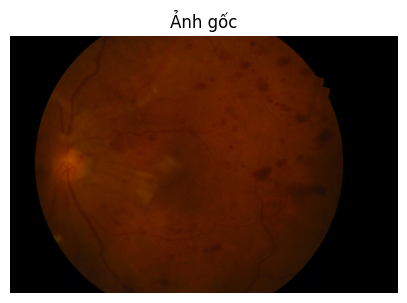

In [19]:
# Thay đường dẫn cho phù hợp
image_path = "/content/drive/MyDrive/IDRID_20/IDRiD_001.jpg"
orig_bgr = cv2.imread(image_path)
orig_bgr = cv2.resize(orig_bgr, (int(orig_bgr.shape[1]*0.25), int(orig_bgr.shape[0]*0.25)))
orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(orig_rgb)
plt.title("Ảnh gốc")
plt.axis('off')


Cell 4: Tối ưu tham số bằng MPA

In [20]:
best_params, best_fit = optimize_params(orig_bgr, epochs=30, pop_size=30)
gamma, alphaV, betaL, k = best_params
print(f"Tham số tối ưu (gamma, alphaV, betaL, k): {best_params}")

INFO:mealpy.swarm_based.MPA.OriginalMPA:OriginalMPA(epoch=30, pop_size=30)
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 1, Current best: -57.414244199611026, Global best: -57.414244199611026, Runtime: 7.89748 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 2, Current best: -57.414244199611026, Global best: -57.414244199611026, Runtime: 5.68452 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 3, Current best: -57.414244199611026, Global best: -57.414244199611026, Runtime: 4.14908 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 4, Current best: -57.414244199611026, Global best: -57.414244199611026, Runtime: 3.80363 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 5, Current best: -57.414244199611026, Global best: -57.414244199611026, Runtime: 2.92002 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 6, Current best: -57.414244199611026, Global best: -57.4142441996110

Tham số tối ưu (gamma, alphaV, betaL, k): [1.29997625 1.25609401 1.20223407 1.89946911]


Cell 5: Áp dụng Gamma correction & αV rồi hiển thị

(np.float64(-0.5), np.float64(1071.5), np.float64(711.5), np.float64(-0.5))

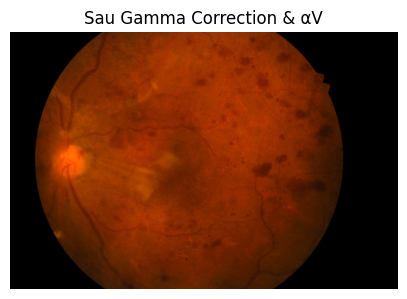

In [21]:
img_gamma = apply_gamma_alphaV_minmax(orig_bgr, gamma, alphaV)
img_gamma_rgb = cv2.cvtColor(img_gamma, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img_gamma_rgb)
plt.title("Sau Gamma Correction & αV")
plt.axis('off')


Cell 6: Áp dụng CLAHE & βL rồi hiển thị

(np.float64(-0.5), np.float64(1071.5), np.float64(711.5), np.float64(-0.5))

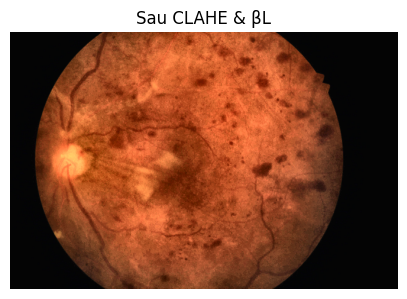

In [22]:
# Tách bước CLAHE riêng để dễ hiển thị
lab = cv2.cvtColor(img_gamma, cv2.COLOR_BGR2LAB)
L, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
L_cl = clahe.apply(L)
L_new = np.clip(betaL * L_cl, 0, 255).astype(np.uint8)
lab_new = cv2.merge((L_new, a, b))
img_clahe = cv2.cvtColor(lab_new, cv2.COLOR_LAB2BGR)
img_clahe_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img_clahe_rgb)
plt.title("Sau CLAHE & βL")
plt.axis('off')


Cell 7: Áp dụng Unsharp Masking (k) rồi hiển thị

(np.float64(-0.5), np.float64(1071.5), np.float64(711.5), np.float64(-0.5))

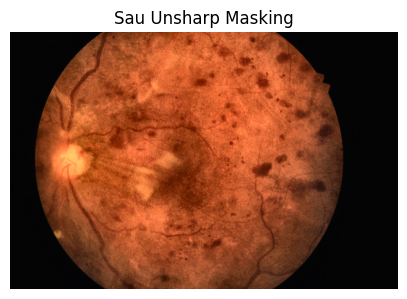

In [23]:
hsv = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(hsv)
blur = cv2.GaussianBlur(V, (5,5), 0.5)
mask = cv2.subtract(V, blur)
V_sharp = np.clip(V.astype(np.float32) + k * mask.astype(np.float32), 0, 255).astype(np.uint8)
hsv_sharp = cv2.merge((H, S, V_sharp))
img_sharp = cv2.cvtColor(hsv_sharp, cv2.COLOR_HSV2BGR)
img_sharp_rgb = cv2.cvtColor(img_sharp, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img_sharp_rgb)
plt.title("Sau Unsharp Masking")
plt.axis('off')


Cell 8: So sánh ảnh gốc – cuối cùng và tính chỉ số

Gốc: (np.float32(0.108473845), np.float32(0.0059972424), np.float32(4.383123), np.float32(0.023171568))
Sau cùng: (np.float32(0.27611595), np.float32(0.040640995), np.float32(5.8600407), np.float32(0.14377077))


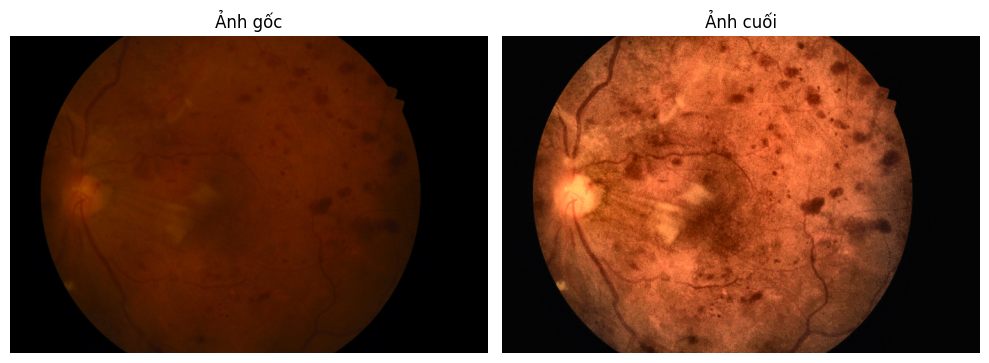

In [24]:
# Hiển thị so sánh
plt.figure(figsize=(10,5))
for i, im in enumerate([orig_rgb, img_sharp_rgb]):
    plt.subplot(1,2,i+1)
    plt.imshow(im)
    plt.title(["Ảnh gốc", "Ảnh cuối"][i])
    plt.axis('off')
plt.tight_layout()

# Tính chỉ số chất lượng
print("Gốc:", evaluate_image_quality(orig_rgb))
print("Sau cùng:", evaluate_image_quality(img_sharp_rgb))
